# Import Package and Set Parameter

In [1]:
import boto3
import cv2
import time
import matplotlib.pyplot as plt

project_arn='arn:aws:rekognition:ap-southeast-1:587870167769:project/TargetDetection/1639029726579'
model_arn='arn:aws:rekognition:ap-southeast-1:587870167769:project/TargetDetection/version/TargetDetection.2021-12-21T14.31.57/1640071917528'
min_inference_units=1 
version_name='TargetDetection.2021-12-21T14.31.57'

min_confidence = 95

# Start Model

In [30]:
def start_model(project_arn, model_arn, version_name, min_inference_units):
    client=boto3.client('rekognition')

    try:
        # Start the model
        print('Starting model: ' + model_arn)
        response=client.start_project_version(ProjectVersionArn=model_arn, MinInferenceUnits=min_inference_units)
        # Wait for the model to be in the running state
        project_version_running_waiter = client.get_waiter('project_version_running')
        project_version_running_waiter.wait(ProjectArn=project_arn, VersionNames=[version_name])

        #Get the running status
        describe_response=client.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])
        for model in describe_response['ProjectVersionDescriptions']:
            print("Status: " + model['Status'])
            print("Message: " + model['StatusMessage']) 
    except Exception as e:
        print(e)
        
    print('Done...')
    

start_model(project_arn, model_arn, version_name, min_inference_units)

Starting model: arn:aws:rekognition:ap-southeast-1:587870167769:project/TargetDetection/version/TargetDetection.2021-12-21T14.31.57/1640071917528
Status: RUNNING
Message: The model is running.
Done...


# Single Prediction

Label target
Confidence 95.33599853515625


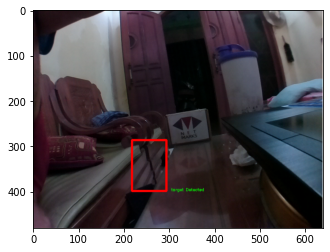

In [43]:
client = boto3.client("rekognition")
image_raw = cv2.imread("opencv_frame_2.png")
image_raw = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
image = cv2.imencode('.jpg', image_raw)[1].tobytes()
response = client.detect_custom_labels(Image={'Bytes': image}, MinConfidence=min_confidence, ProjectVersionArn=model_arn)
imgWidth, imgHeight = 480, 640
for customLabel in response['CustomLabels']:
    print('Label ' + str(customLabel['Name']))
    print('Confidence ' + str(customLabel['Confidence']))
    if 'Geometry' in customLabel:
        box = customLabel['Geometry']['BoundingBox']
        left = imgWidth * box['Left']
        top = imgHeight * box['Top']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']
        start = (int(left),int(top))
        end = (int(left+width),int(top+height))
        cv2.rectangle(image_raw, pt1=start, pt2=end, color=(255,0,0), thickness=3)
        cv2.putText(image_raw, f"{customLabel['Name']} Detected", (end[0]+10, end[1]), 0, 0.3, (0,255,0))
plt.imshow(image_raw);

# Streaming Prediction

In [7]:
client=boto3.client('rekognition')

vid = cv2.VideoCapture(0)
  
while(True):
    now = time.time()
    ret, frame = vid.read()
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = cv2.imencode('.jpg', image)[1].tobytes()
    response = client.detect_custom_labels(Image={'Bytes': image}, MinConfidence=min_confidence, ProjectVersionArn=model_arn)
    imgWidth, imgHeight = 480, 640
    print(response)
    
    for customLabel in response['CustomLabels']:
        print('Label ' + str(customLabel['Name']))
        print('Confidence ' + str(customLabel['Confidence']))
        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']
            start = (left,top)
            end = (left+width,top+height)
            print("start = ", start)
            print("end = ", end)
            cv2.rectangle(frame, start, end, (255,0,0), 2)
            cv2.putText(frame, f"{customLabel['Name']} Detected", (left+width+10, top+height), 0, 0.3, (0,255,0))

    cv2.imshow('frame', frame)
    print(f"fps : {1/(time.time()-now)}")
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
vid.release()
cv2.destroyAllWindows()

{'CustomLabels': [], 'ResponseMetadata': {'RequestId': '13860c33-14d4-4759-b5d0-a69f93796a39', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '13860c33-14d4-4759-b5d0-a69f93796a39', 'content-type': 'application/x-amz-json-1.1', 'content-length': '19', 'date': 'Tue, 21 Dec 2021 09:34:42 GMT'}, 'RetryAttempts': 0}}
fps : 0.7968582426578559
{'CustomLabels': [], 'ResponseMetadata': {'RequestId': '81124a22-67db-4ef2-959c-bb0e70bc991e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '81124a22-67db-4ef2-959c-bb0e70bc991e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '19', 'date': 'Tue, 21 Dec 2021 09:34:42 GMT'}, 'RetryAttempts': 0}}
fps : 1.988650248136546
{'CustomLabels': [], 'ResponseMetadata': {'RequestId': 'c1d3a245-76e6-4667-a530-30a51f531ead', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c1d3a245-76e6-4667-a530-30a51f531ead', 'content-type': 'application/x-amz-json-1.1', 'content-length': '19', 'date': 'Tue, 21 Dec 2021 09:34:4

# Stop Model

In [44]:
def stop_model(model_arn):

    client=boto3.client('rekognition')

    print('Stopping model:' + model_arn)

    #Stop the model
    try:
        response=client.stop_project_version(ProjectVersionArn=model_arn)
        status=response['Status']
        print ('Status: ' + status)
    except Exception as e:  
        print(e)  

    print('Done...')

stop_model(model_arn)

Stopping model:arn:aws:rekognition:ap-southeast-1:587870167769:project/TargetDetection/version/TargetDetection.2021-12-21T14.31.57/1640071917528
An error occurred (ResourceInUseException) when calling the StopProjectVersion operation: ProjectVersion arn:aws:rekognition:ap-southeast-1:587870167769:project/TargetDetection/version/TargetDetection.2021-12-21T14.31.57/1640071917528 is STOPPED; cannot be stopped
Done...
